In [1]:
import torch
import scipy.io

import matplotlib.pyplot as plt
from PIL import Image

import os

import mat73

import torch
import torch.nn.functional as F

import numpy as np

import copy
from tqdm import tqdm

In [2]:
file = 'nyu_depth_v2_labeled.mat'

In [3]:
data = mat73.loadmat(file)

ERROR:root:ERROR: MATLAB type not supported: containers.Map, (uint32)


In [4]:
data.keys()

dict_keys(['accelData', 'depths', 'images', 'instances', 'labels', 'names', 'namesToIds', 'rawDepthFilenames', 'rawDepths', 'rawRgbFilenames', 'sceneTypes', 'scenes'])

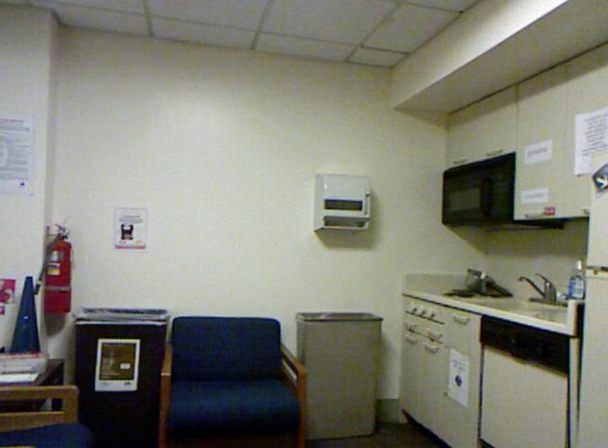

In [5]:
i = 0
# images = data['labels'][16:-16, 16:-16, :]
# im = Image.fromarray(images[:, :, i]*2555)
images = data['images'][16:-16, 16:-16, :, :]
im = Image.fromarray(images[:, :, :, i])
im

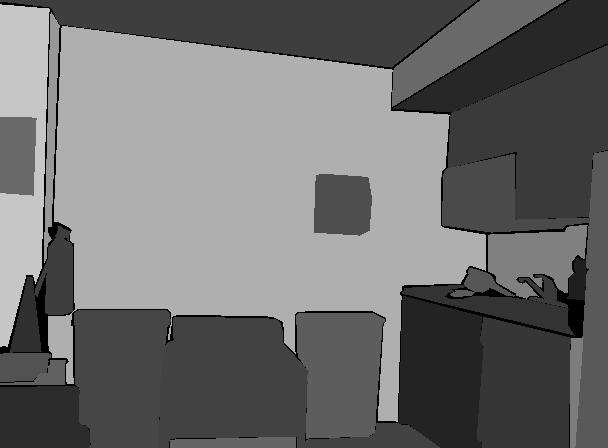

In [7]:
i = 0
# images = data['labels'][16:-16, 16:-16, :]
# im = Image.fromarray(images[:, :, i]*2555)
labels = data['labels'][16:-16, 16:-16, :]
instances = data['instances'][16:-16, 16:-16, :]
ins = Image.fromarray((instances[:, :, i]*6000)+(labels[:, :, i]*1000))
ins

In [227]:
# for i, img in enumerate(data_img):
#     im = Image.fromarray(img)
#     # im = im.resize((256,256),Image.ANTIALIAS)
#     im.save(os.path.join(r'C:\Users\appel\Documents\Project\simulation-synthesis\output\608x448\labeled_real'+"\{}_img.png".format(i)))

In [26]:
def nninterpolation(im, replace_val = 0, max_distance = 5):

    nn_interpolation = copy.deepcopy(im)

    intp_found = False

    for x, row in enumerate(im):
        for y, value in enumerate(row):
            if value == 0:
                i = 0
                while not intp_found and i < max_distance:
                    i+=1
                    if y-i >= 0:
                        left = im[x, y-i]
                        if left != replace_val:
                            nn_interpolation[x,y] = left
                            intp_found = True
                            break

                    if y+i < im.shape[1]:
                        right = im[x, y+i]
                        if right != replace_val:
                            nn_interpolation[x,y] = right
                            intp_found = True
                            break

                    if x-i >= 0:
                        up = im[x-i, y]
                        if up != replace_val:
                            nn_interpolation[x,y] = up
                            intp_found = True
                            break

                    if x+i < im.shape[0]:
                        down = im[x+i, y]
                        if down != replace_val:
                            nn_interpolation[x,y] = down
                            intp_found = True
                            break
                
            intp_found = False

    return nn_interpolation

In [32]:
combined = (6000*instances + 1000*labels).transpose(2,0,1)

interpolated_ins = copy.deepcopy(combined)

for i, img in enumerate(tqdm(combined)):
    interpolated_ins[i] = nninterpolation(img)

100%|██████████| 1449/1449 [25:58<00:00,  1.08s/it] 


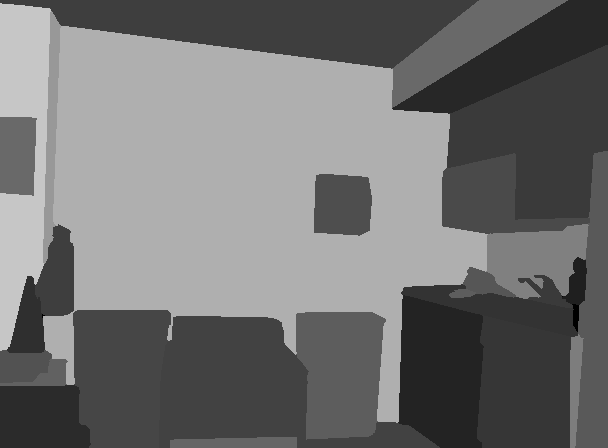

In [33]:
Image.fromarray(interpolated_ins[0])

In [34]:
def edges(img):
    
    _edges = np.zeros_like(img)

    for x, row in enumerate(img):
        for y, value in enumerate(row):

            neighbours = []
            if y-1 > 0:
                left = img[x, y-1]
                if left != value:
                    neighbours.append(left)

            if x-1 > 0:
                up = img[x-1, y]
                if up != value:
                    neighbours.append(up)

            if len(neighbours) > 0:
                _edges[x, y] = 1

    return _edges

In [35]:
_edges = np.zeros_like(interpolated_ins)

for i, img in tqdm(enumerate(interpolated_ins)):
    _edges[i] = edges(img)

1449it [04:15,  5.67it/s]


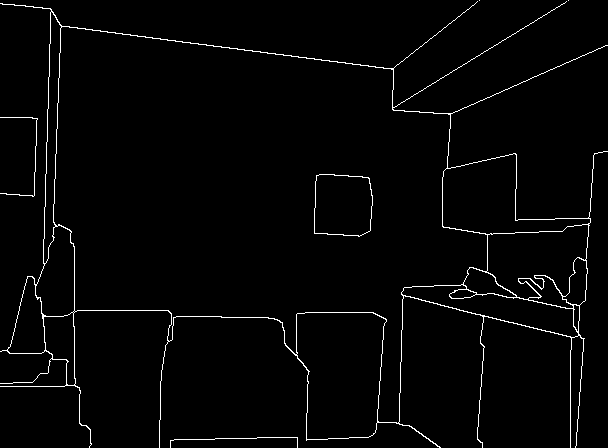

In [36]:
Image.fromarray((_edges[0]==1))

In [ ]:
for i, img in enumerate(_edges):
    im = Image.fromarray(img==1)
    # im = im.resize((256,256),Image.ANTIALIAS)
    im.save(os.path.join(r'C:\Users\appel\Documents\Project\simulation-synthesis\output\448\labeled_real'+"\{}_outlines.png".format(i)))

In [ ]:
for i, img in enumerate(interpolated_ins):
    im = Image.fromarray(img*2000)
    # im = im.resize((256,256),Image.ANTIALIAS)
    im.save(os.path.join(r'C:\Users\appel\Documents\Project\simulation-synthesis\output\448\labeled_real'+"\{}_instances.png".format(i)))